In [1]:
# ex 7.2 - comparing a live TD error vs a "proper" n-step boostrapping approach

In [2]:
import numpy as np

## Accurate $v_\pi$ calculation

In [326]:
from itertools import count

n_states = 19  # random walk - choose odd number so there's a midpoint please :)
n = 4
alpha = 0.1
n_episodes = 10_000


def mod(val):
    return val % (n + 1)


# print(f'{n=}')
V = np.zeros(n_states)
R = np.zeros(n)
S = np.zeros(n, dtype=int)

td_errs = []
for ne in range(n_episodes):
    T = np.inf
    S = np.zeros(n + 1, dtype=int)
    R = np.zeros(1)
    S[0] = n_states // 2  # start at midpoint
    # print(f"0: {S[0]=}")
    for t in count():
        if t < T:
            a = np.random.randint(0, 2) * 2 - 1  # 50% chance of -1, +1
            s = S[t % (n + 1)] + a
            S[(t + 1) % (n + 1)] = s
            if s == n_states - 1:
                R = np.append(R, 1)
                T = t + 1
            elif s == 0:
                R = np.append(R, -1)
                T = t + 1
            else:
                R = np.append(R, 0)

        #     print(f"{t}: A_t+1={a}, {s=}, r={R[t+1]}")

        # print(f"  S: {S}")
        # print(f"  R: {R}")

        tau = t - n + 1
        if tau >= 0:
            G = R[tau + 1 :].sum()
            if tau + n < T:
                G += V[S[(tau + n) % (n + 1)]]
            V[S[tau % (n + 1)]] += (alpha / np.sqrt(ne / 5 + 1)) * (
                G - V[S[tau % (n + 1)]]
            )
            # print(f"{t}: Updated state S[{tau} ({tau})]={S[tau]}")

        if tau == T - 1:
            break

    # errs.append(((V_accurate - V) ** 2).sum())

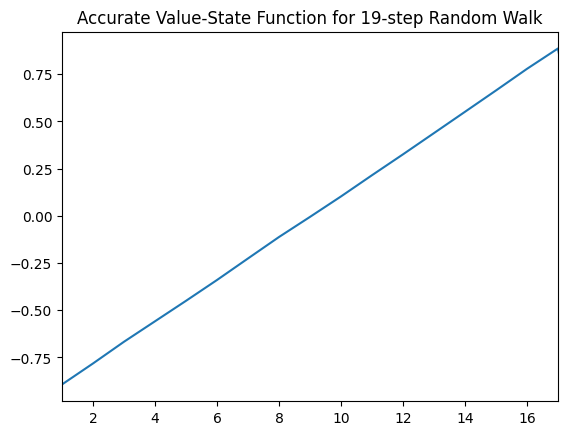

In [312]:
import matplotlib.pyplot as plt

plt.plot(V.reshape(-1, 1))
plt.xlim(1, len(V) - 2)
plt.title("Accurate Value-State Function for 19-step Random Walk")
# V_accurate = V.copy()
plt.show()

In [272]:
V[n_states // 2]

-0.00020967159549221858

## Normal TD Loss

In [389]:
# Normal version - low episode count
# from itertools import count
n_states = 19  # random walk - choose odd number so there's a midpoint please :)
n = 64
alpha = 0.1
n_episodes = 2_000


def sim_episode_normal(n: int = 4, alpha=0.1, n_episodes=2000):
    V_nm = np.zeros(n_states)
    V_er = np.zeros(n_states)

    nm_errs = []
    td_errs = []
    for ne in range(n_episodes):
        T = np.inf
        S = np.zeros(n + 1, dtype=int)
        R = np.zeros(1)
        delta = np.zeros(0)
        S[0] = n_states // 2  # start at midpoint
        # print(f"0: {S[0]=}")
        for t in count():
            if t < T:
                a = np.random.randint(0, 2) * 2 - 1  # 50% chance of -1, +1
                s = S[t % (n + 1)] + a
                S[(t + 1) % (n + 1)] = s
                if s == n_states - 1:
                    r = 1
                    T = t + 1
                elif s == 0:
                    r = -1
                    T = t + 1
                else:
                    r = 0
                R = np.append(R, r)
                delta_t = r + V_er[S[(t + 1) % (n + 1)]] - V_er[S[t % (n + 1)]]
                delta = np.append(delta, delta_t)
            #     print(f"{t}: A_t+1={a}, {s=}, r={R[t+1]}")

            # print(f"  S: {S}")
            # print(f"  R: {R}")

            tau = t - n + 1
            if tau >= 0:
                # normal update
                G = R[tau + 1 :].sum()
                if tau + n < T:
                    G += V_nm[S[(tau + n) % (n + 1)]]
                V_nm[S[tau % (n + 1)]] += (alpha / np.sqrt(ne / 5 + 1)) * (
                    G - V_nm[S[tau % (n + 1)]]
                )
                # TD error update
                G_min_V = delta[tau:].sum()
                V_er[S[tau % (n + 1)]] += (alpha / np.sqrt(ne / 5 + 1)) * (G_min_V)

                # print(f"{t}: Updated state S[{tau} ({tau})]={S[tau]}")

            if tau == T - 1:
                break

        if ne % 10:
            nm_errs.append(np.sum(np.square(V_nm - V_accurate)))
            td_errs.append(np.sum(np.square(V_er - V_accurate)))

    return nm_errs, td_errs, V


nm_errs_4 = []
td_errs_4 = []
nm_errs_32 = []
td_errs_32 = []
nm_errs_64 = []
td_errs_64 = []
for _ in range(100):
    nm_err_4, td_err_4, V = sim_episode_normal(n=4)
    nm_errs_4.append(nm_err_4)
    td_errs_4.append(td_err_4)

    nm_err_32, td_err_32, V = sim_episode_normal(n=32)
    nm_errs_32.append(nm_err_32)
    td_errs_32.append(td_err_32)

    nm_err_64, td_err_64, V = sim_episode_normal(n=64)
    nm_errs_64.append(nm_err_64)
    td_errs_64.append(td_err_64)

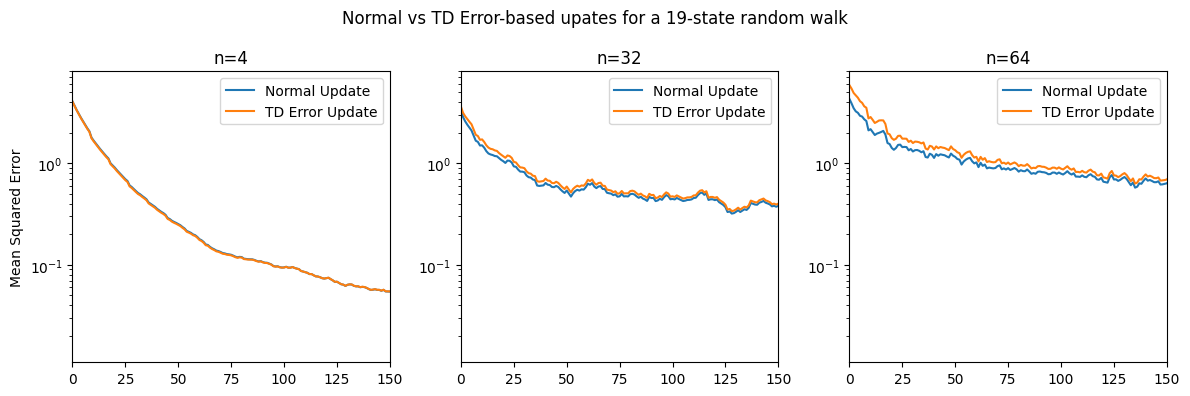

In [415]:
# TD Error version
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

xlim = (0, 150)
ylim = (0.011, 8)
fig.suptitle("Normal vs TD Error-based upates for a 19-state random walk")
axes[0].plot(np.array(nm_errs_4).mean(axis=0), label="Normal Update")
axes[0].plot(np.array(td_errs_4).mean(axis=0), label="TD Error Update")
axes[0].set_title("n=4")
axes[0].set_yscale("log")
axes[0].set_ylabel("Mean Squared Error")
axes[0].set_ylim(ylim)
axes[0].set_xlim(xlim)
axes[0].legend()

axes[1].plot(np.array(nm_errs_32).mean(axis=0), label="Normal Update")
axes[1].plot(np.array(td_errs_32).mean(axis=0), label="TD Error Update")
axes[1].set_title("n=32")
axes[1].set_yscale("log")
axes[1].set_ylim(ylim)
axes[1].set_xlim(xlim)
axes[1].legend()


axes[2].plot(np.array(nm_errs_64).mean(axis=0), label="Normal Update")
axes[2].plot(np.array(td_errs_64).mean(axis=0), label="TD Error Update")
axes[2].set_title("n=64")
axes[2].set_yscale("log")
axes[2].set_ylim(ylim)
axes[2].set_xlim(xlim)
axes[2].legend()

plt.tight_layout()
plt.show()

## TD Error Calculation

In [378]:
# Normal version - low episode count
# from itertools import count
n_states = 19  # random walk - choose odd number so there's a midpoint please :)
n = 4
alpha = 0.1
n_episodes = 2_000


def sim_episode_td_error():
    V = np.zeros(n_states)

    errs = []
    for ne in range(n_episodes):
        T = np.inf
        S = np.zeros(n + 1, dtype=int)
        R = np.zeros(1)
        delta = np.zeros(0)
        S[0] = n_states // 2  # start at midpoint
        # print(f"0: {S[0]=}")
        for t in count():
            if t < T:
                a = np.random.randint(0, 2) * 2 - 1  # 50% chance of -1, +1
                s = S[t % (n + 1)] + a
                S[(t + 1) % (n + 1)] = s
                if s == n_states - 1:
                    r = 1
                    T = t + 1
                elif s == 0:
                    r = -1
                    T = t + 1
                else:
                    r = 0
                R = np.append(R, r)
                delta_t = r + V[S[(t + 1) % (n + 1)]] - V[S[t % (n + 1)]]
                delta = np.append(delta, delta_t)

            #     print(f"{t}: A_t+1={a}, {s=}, r={R[t+1]}")

            # print(f"  S: {S}")
            # print(f"  R: {R}")

            tau = t - n + 1
            if tau >= 0:
                G_min_V = delta[tau:].sum()
                V[S[tau % (n + 1)]] += (alpha / np.sqrt(ne / 5 + 1)) * (G_min_V)
                # print(f"{t}: Updated state S[{tau} ({tau})]={S[tau]}")

            if tau == T - 1:
                break

        if ne % 10:
            errs.append(np.sum(np.square(V - V_accurate)))

    return errs, V


td_err_errs = []
for _ in range(100):
    td_errs, V_td = sim_episode_td_error()
    td_err_errs.append(td_errs)

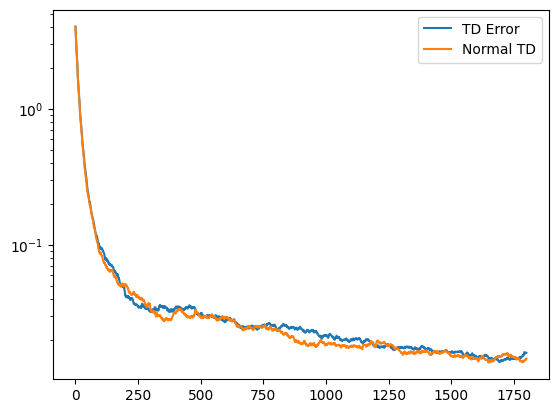

In [379]:
# TD Error version
plt.plot(np.array(td_err_errs).mean(axis=0), label="TD Error")
plt.plot(np.array(nm_errs).mean(axis=0), label="Normal TD")
plt.yscale("log")
plt.legend()
plt.show()

In [375]:
V = np.zeros(n_states)

errs = []
for ne in range(100):
    T = np.inf
    S = np.zeros(n + 1, dtype=int)
    R = np.zeros(1)
    delta = np.zeros(0)
    S[0] = n_states // 2  # start at midpoint
    # print(f"0: {S[0]=}")
    for t in count():
        if t < T:
            a = np.random.randint(0, 2) * 2 - 1  # 50% chance of -1, +1
            s = S[t % (n + 1)] + a
            S[(t + 1) % (n + 1)] = s
            if s == n_states - 1:
                r = 1
                T = t + 1
            elif s == 0:
                r = -1
                T = t + 1
            else:
                r = 0
            R = np.append(R, r)
            delta_t = r + V[S[(t + 1) % (n + 1)]] - V[S[t % (n + 1)]]
            delta = np.append(delta, delta_t)

            # print(f"{t}: A_t+1={a}, {s=}, r={R[t+1]}")

        # print(f"  S: {S}")
        # print(f"  R: {R}")

        tau = t - n + 1
        if tau >= 0:
            G_min_V = delta[tau:].sum()
            V[S[tau % (n + 1)]] += (alpha / np.sqrt(ne / 5 + 1)) * (G_min_V)
            # print(f"{G_min_V=}")
            # print(f"{t}: Updated state S[{tau} ({tau})]={S[tau % (n + 1)]}")

        if tau == T - 1:
            break

    if ne % 10:
        errs.append(np.sum(np.square(V - V_accurate)))